In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/HAZY_DEHAZY"

/content/drive/MyDrive/HAZY_DEHAZY


In [ ]:
!pwd

/content/drive/MyDrive/HAZY_DEHAZY


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torchvision.utils import save_image
torch.backends.cudnn.benchmark = True

In [ ]:
class config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TRAIN_DIR = "data/train"
    VAL_DIR = "data/val"
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 8
    NUM_WORKERS = 2
    IMAGE_SIZE = 256
    CHANNELS_IMG = 3
    L1_LAMBDA = 100
    LAMBDA_GP = 10
    NUM_EPOCHS = 50
    LOAD_MODEL = False
    SAVE_MODEL = True
    CHECKPOINT_GEN = "models/gen.pth.tar"

    both_transform = A.Compose(
        [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
    )

    transform_only_input = A.Compose(
        [
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
            ToTensorV2(),
        ]
    )

    transform_only_mask = A.Compose(
        [
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
            ToTensorV2(),
        ]
    )

In [ ]:
def display_random_example(gen, val_loader):
    gen.eval()
    with torch.no_grad():
        x, y = random.choice(val_loader.dataset)  # Randomly pick an image
        x, y = x.unsqueeze(0).to(config.DEVICE), y.unsqueeze(0).to(config.DEVICE)  # Add batch dimension
        y_fake = gen(x)
        x = x * 0.5 + 0.5  # remove normalization
        y = y * 0.5 + 0.5  # remove normalization
        y_fake = y_fake * 0.5 + 0.5  # remove normalization

    plt.figure(figsize=(10, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(x.cpu().squeeze().permute(1, 2, 0))
    plt.axis('off')

    # Display generated image
    plt.subplot(1, 3, 2)
    plt.title('Generated Image')
    plt.imshow(y_fake.cpu().squeeze().permute(1, 2, 0))
    plt.axis('off')

    # Display ground truth image
    plt.subplot(1, 3, 3)
    plt.title('Ground Truth Image')
    plt.imshow(y.cpu().squeeze().permute(1, 2, 0))
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [ ]:
class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, 256:, :]
        target_image = image[:, :256, :]

        augmentations = config.both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = config.transform_only_input(image=input_image)["image"]
        target_image = config.transform_only_mask(image=target_image)["image"]

        return input_image, target_image

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )

        self.final = nn.Conv2d(features[0], 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.final(x)
        return x

In [ ]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True):
        super(Block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1) if down else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.conv(x))

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Conv2d(in_channels, features, 4, 2, 1)
        self.down1 = Block(features, features * 2)
        self.bottleneck = nn.Conv2d(features * 2, features * 4, 4, 2, 1)
        self.up1 = Block(features * 4, features * 2, down=False)
        self.final_up = nn.ConvTranspose2d(features * 2, in_channels, 4, 2, 1)

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        bottleneck = self.bottleneck(d2)
        up1 = self.up1(bottleneck)
        return self.final_up(up1)

In [ ]:
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):

    total_D_real_loss = 0
    total_D_fake_loss = 0
    total_G_loss = 0
    total_L1_loss = 0

    for idx, (x, y) in enumerate(loader):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        # Train Discriminator and generator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * config.L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Collect loss values
        total_D_real_loss += D_real_loss.item()
        total_D_fake_loss += D_fake_loss.item()
        total_G_loss += G_fake_loss.item()
        total_L1_loss += L1.item()

    # Calculate average losses
    avg_D_real_loss = total_D_real_loss / len(loader)
    avg_D_fake_loss = total_D_fake_loss / len(loader)
    avg_G_loss = total_G_loss / len(loader)
    avg_L1_loss = total_L1_loss / len(loader)

    print(f"\t Train Losses: D_real: {avg_D_real_loss:.5f}| D_fake: {avg_D_fake_loss:.5f}| G: {avg_G_loss:.5f}| L1: {avg_L1_loss:.5f}")

    # Return the average losses
    return avg_D_real_loss, avg_D_fake_loss, avg_G_loss, avg_L1_loss

In [ ]:
def validate_fn(disc, gen, loader, l1_loss, bce):
    disc.eval()
    gen.eval()
    total_D_real_loss = 0
    total_D_fake_loss = 0
    total_G_loss = 0
    total_L1_loss = 0

    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(config.DEVICE)
            y = y.to(config.DEVICE)

            # Discriminator loss
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            total_D_real_loss += D_real_loss.item()
            total_D_fake_loss += D_fake_loss.item()

            # Generator loss
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1_loss = l1_loss(y_fake, y) * config.L1_LAMBDA
            total_G_loss += G_fake_loss.item()
            total_L1_loss += L1_loss.item()

    avg_D_real_loss = total_D_real_loss / len(loader)
    avg_D_fake_loss = total_D_fake_loss / len(loader)
    avg_G_loss = total_G_loss / len(loader)
    avg_L1_loss = total_L1_loss / len(loader)

    print(f"\t Valid Losses: D_real: {avg_D_real_loss:.5f}| D_fake: {avg_D_fake_loss:.5f}| G: {avg_G_loss:.5f}| L1: {avg_L1_loss:.5f}")

    disc.train()
    gen.train()

    return avg_D_real_loss, avg_D_fake_loss, avg_G_loss, avg_L1_loss

In [ ]:
discriminator = Discriminator(in_channels=3).to(config.DEVICE)
print(discriminator)

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): Batc

In [ ]:
generator = Generator(in_channels=3, features=64).to(config.DEVICE)
print(generator)

Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

In [ ]:
def main(disc, gen):
    opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    train_dataset = MapDataset(root_dir=config.TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    val_dataset = MapDataset(root_dir=config.VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    train_D_real_loss_list = []
    train_D_fake_loss_list = []
    train_G_loss_list = []
    train_L1_loss_list = []

    val_D_real_loss_list = []
    val_D_fake_loss_list = []
    val_G_loss_list = []
    val_L1_loss_list = []
    for epoch in range(config.NUM_EPOCHS):
        print(f"\n Epoch {epoch+1}/{config.NUM_EPOCHS}:")
        train_D_real_loss, train_D_fake_loss, train_G_loss, train_L1_loss = train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
        val_D_real_loss, val_D_fake_loss, val_G_loss, val_L1_loss = validate_fn(disc, gen, val_loader, L1_LOSS, BCE)

        train_D_real_loss_list.append(train_D_real_loss)
        train_D_fake_loss_list.append(train_D_fake_loss)
        train_G_loss_list.append(train_G_loss)
        train_L1_loss_list.append(train_L1_loss)

        val_D_real_loss_list.append(val_D_real_loss)
        val_D_fake_loss_list.append(val_D_fake_loss)
        val_G_loss_list.append(val_G_loss)
        val_L1_loss_list.append(val_L1_loss)

        if config.SAVE_MODEL and (epoch+1) % 10 == 0:
            save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
        if (epoch+1) % 5 == 0:
            display_random_example(gen, val_loader)
    return train_D_real_loss_list, train_D_fake_loss_list, train_G_loss_list, train_L1_loss_list, val_D_real_loss_list, val_D_fake_loss_list, val_G_loss_list, val_L1_loss_list

In [ ]:
train_D_real_loss_list, train_D_fake_loss_list, train_G_loss_list, train_L1_loss_list, val_D_real_loss_list, val_D_fake_loss_list, val_G_loss_list, val_L1_loss_list = main(discriminator, generator)

Output hidden; open in https://colab.research.google.com to view.

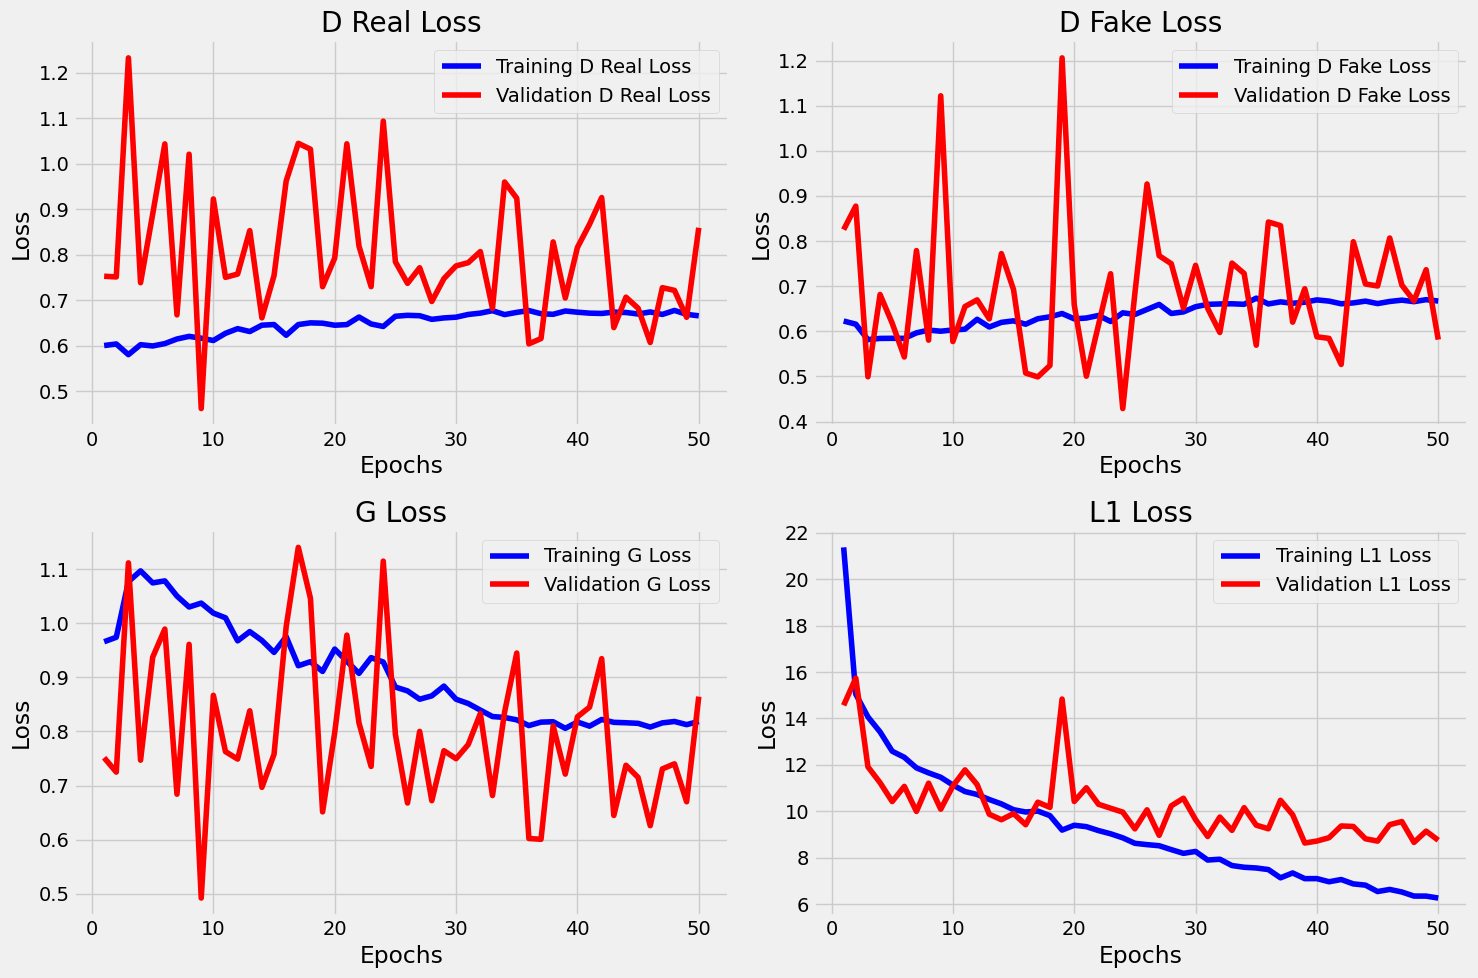

In [ ]:
epochs = range(1, config.NUM_EPOCHS + 1)

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(15, 10))
    plt.rcParams["font.size"] = 14

    plt.subplot(221)
    plt.plot(epochs, train_D_real_loss_list, 'b', label='Training D Real Loss')
    plt.plot(epochs, val_D_real_loss_list, 'r', label='Validation D Real Loss')
    plt.title('D Real Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(222)
    plt.plot(epochs, train_D_fake_loss_list, 'b', label='Training D Fake Loss')
    plt.plot(epochs, val_D_fake_loss_list, 'r', label='Validation D Fake Loss')
    plt.title('D Fake Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(223)
    plt.plot(epochs, train_G_loss_list, 'b', label='Training G Loss')
    plt.plot(epochs, val_G_loss_list, 'r', label='Validation G Loss')
    plt.title('G Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(224)
    plt.plot(epochs, train_L1_loss_list, 'b', label='Training L1 Loss')
    plt.plot(epochs, val_L1_loss_list, 'r', label='Validation L1 Loss')
    plt.title('L1 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()